547
7
Best Hyperparameters: {'depth': 6, 'iterations': 50, 'learning_rate': 0.05}
Mean Absolute Error (MAE): 93.76105413295383


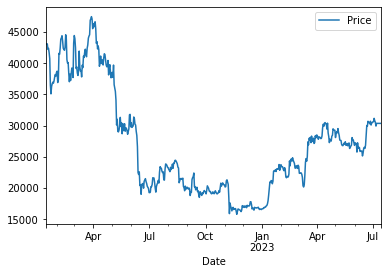

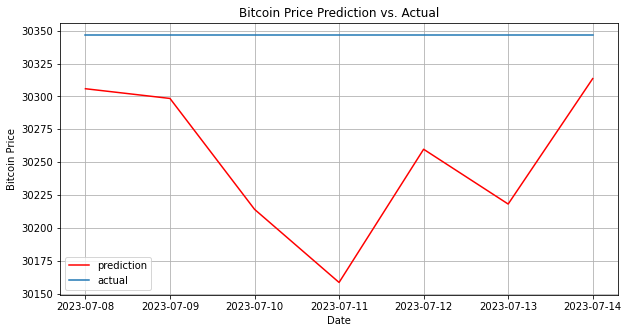

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor # вот она наша жемчужина
from sklearn.model_selection import GridSearchCV

# читаем из CSV файла и указываем разделитель и колонку с датой в качестве индекса
data = pd.read_csv("Bitcoin_kaggle.csv",
                   delimiter=';',
                   parse_dates=True,
                   index_col='Date')

print(len(data))

# делаем сортировку данных по индексу (дате)
data = data.sort_index()
data.tail(10)

# в числовой формат + убираем запятые
data['Price'] = data['Price'].apply(lambda x: float(x.replace(",", "")))

data = data[['Price']]

data.plot()

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

target = "Price"

# временной ряд хотим сделать стационарным
def make_stationary(data):
    data_diff = data.diff().dropna()
    return data_diff

data_stationary = make_stationary(data)

# функция для предобработки данных и создания лаговых переменных
def preprocess_data(data, lag_start=7, lag_end=20, test_size=0.02):
    data = pd.DataFrame(data.copy())

    # индекс для разделения на обучающую и тестовую выборки
    test_index = int(len(data) * (1 - test_size))

    # создание лаговых переменных
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)

    # добавление информации о дне в месяце и среднем значении цены для каждого дня
    data["day"] = data.index.day
    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))
    data.drop(["day"], axis=1, inplace=True)

    # удаление строк с пропущенными значениями после добавления лагов
    data = data.dropna()
    data = data.reset_index(drop=True)

    # разделение на обучающую и тестовую выборки
    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data_stationary, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

# задание сетки гиперпараметров для CatBoost
param_grid = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8],
}

catboost_model = CatBoostRegressor(random_seed=42, verbose=False)

# Поиск по сетке гиперпараметров с использованием GridSearchCV
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Получение лучших гиперпараметров из поиска
best_params = grid_search.best_params_

# Юзаем только лучшее
catboost_model = CatBoostRegressor(**best_params, random_seed=42, verbose=False)
catboost_model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
preds = catboost_model.predict(X_test)

# Преобразование предсказаний в исходную шкалу цен
preds_original_scale = data.iloc[-len(y_test)-1:-1].values.squeeze() + preds.cumsum()

# Вычисление средней абсолютной ошибки
mae = mean_absolute_error(data.iloc[-len(y_test):].values, preds_original_scale)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae}")

# Визуализация предсказаний и фактических значений
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(y_test):], preds_original_scale, "r", label="prediction")
plt.plot(data.index[-len(y_test):], data.iloc[-len(y_test):].values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Bitcoin Price Prediction vs. Actual")

plt.show()

X_test['Date'] = data.index[-7:]
X_test['Price'] = preds_original_scale
X_test.set_index('Date', inplace=True)
X_test[['Price']].to_csv("prediction_catboost_stationary_tuned.csv")